Training samples: 3500
Validation samples: 749
Test samples: 748



Epoch 1/15
Train Loss = 4.717, Val Loss = 4.198, Val Acc = 0.249, Time = 536.0s



Epoch 2/15
Train Loss = 3.664, Val Loss = 3.891, Val Acc = 0.290, Time = 485.9s



Epoch 3/15
Train Loss = 3.007, Val Loss = 3.876, Val Acc = 0.327, Time = 503.8s



Epoch 4/15
Train Loss = 2.479, Val Loss = 3.877, Val Acc = 0.335, Time = 499.7s



Epoch 5/15
Train Loss = 2.008, Val Loss = 4.167, Val Acc = 0.326, Time = 554.3s



Epoch 6/15
Train Loss = 1.624, Val Loss = 4.273, Val Acc = 0.329, Time = 541.9s



Epoch 7/15
Train Loss = 1.276, Val Loss = 4.662, Val Acc = 0.311, Time = 638.5s
Early stopping triggered.


Testing: 100%|██████████| 24/24 [01:29<00:00,  3.74s/it]



Classification Report:
                                                     precision    recall  f1-score   support

                                            almonds       0.00      0.00      0.00         3
                                              apple       0.53      0.77      0.62        13
                                          apple-pie       0.08      0.33      0.12         3
                                           apricots       0.00      0.00      0.00         1
                                          artichoke       0.00      0.00      0.00         1
                                            avocado       0.00      0.00      0.00         4
                                       baked-potato       0.00      0.00      0.00         1
                                             banana       0.88      0.88      0.88         8
                                               beef       0.00      0.00      0.00         2
                                         beef

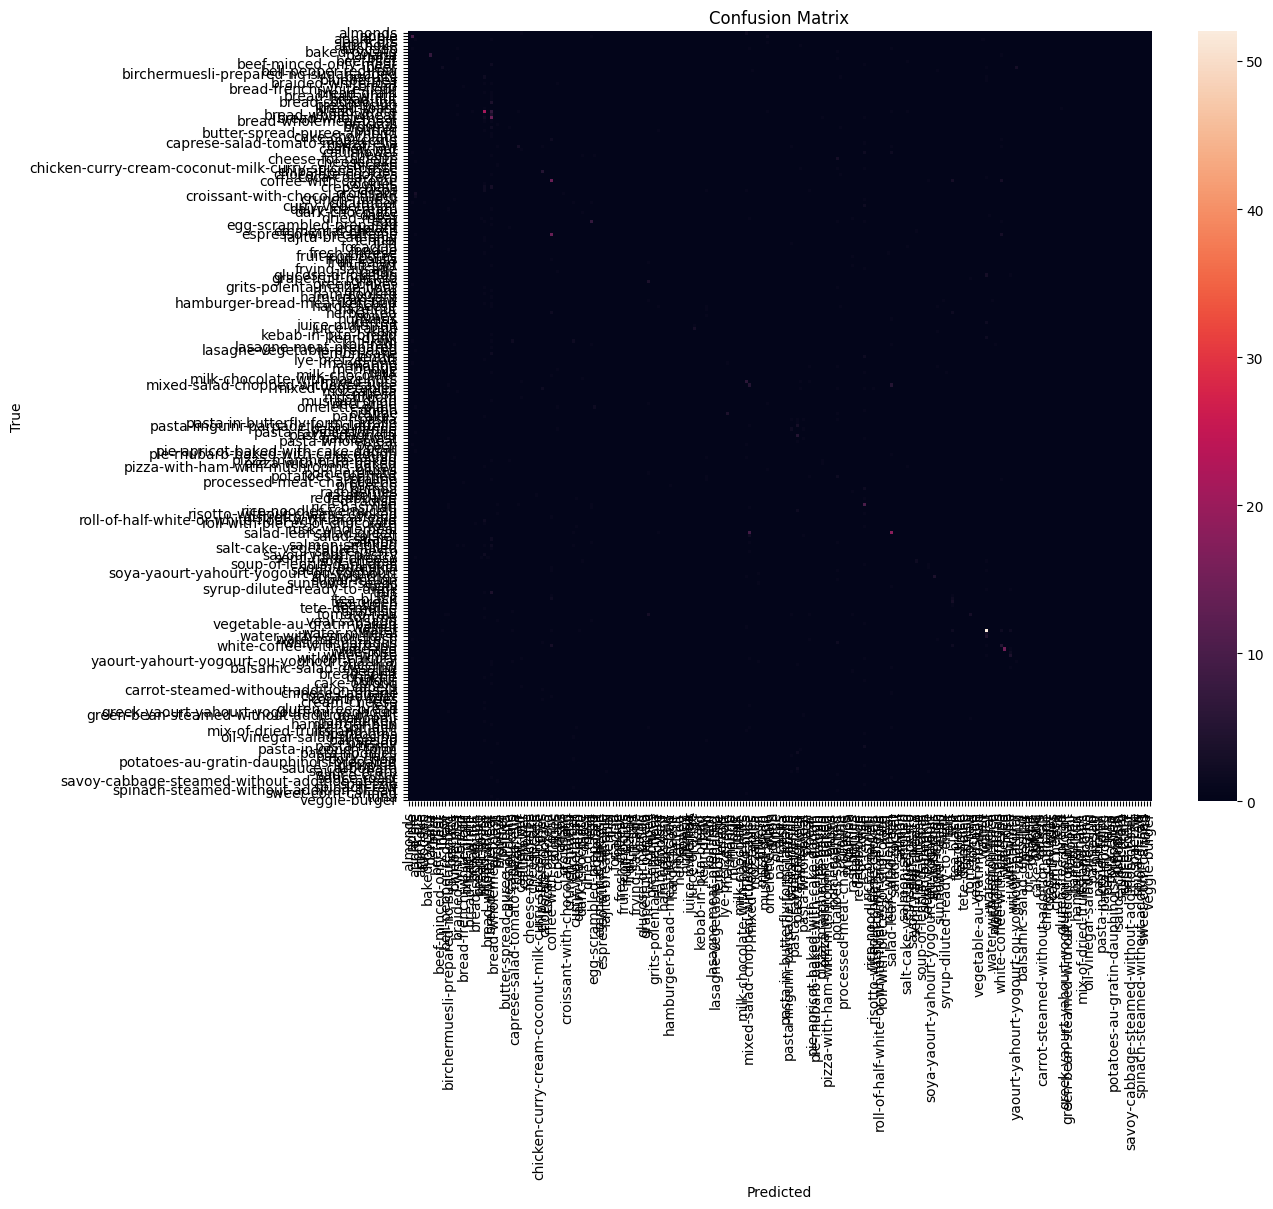

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.045656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0616211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07178223..1.041143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215386..1.08956].


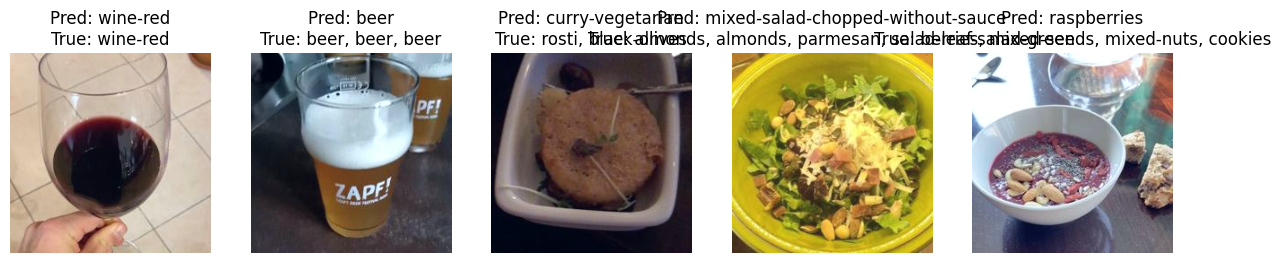

In [4]:
# 1. Imports (same as before)
import os
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
from collections import defaultdict

# 2. Configs (same as before)
data_dir = r'D:\AAmachine learning\Group Project\ImageDatasetResize'

# Single-label paths
train_img_dir = os.path.join(data_dir, 'training', 'img', 'single_labeled')
val_img_dir = os.path.join(data_dir, 'validation', 'img', 'single_labeled')
test_img_dir = os.path.join(data_dir, 'test', 'img', 'single_labeled')
train_ann_dir = os.path.join(data_dir, 'training', 'ann', 'single_labeled')
val_ann_dir = os.path.join(data_dir, 'validation', 'ann', 'single_labeled')
test_ann_dir = os.path.join(data_dir, 'test', 'ann', 'single_labeled')

# Multi-label paths
train_multi_img_dir = os.path.join(data_dir, 'training', 'img', 'multi_labeled')
train_multi_ann_dir = os.path.join(data_dir, 'training', 'ann', 'multi_labeled')
val_multi_img_dir = os.path.join(data_dir, 'validation', 'img', 'multi_labeled')
val_multi_ann_dir = os.path.join(data_dir, 'validation', 'ann', 'multi_labeled')
test_multi_img_dir = os.path.join(data_dir, 'test', 'img', 'multi_labeled')
test_multi_ann_dir = os.path.join(data_dir, 'test', 'ann', 'multi_labeled')

batch_size = 32
num_epochs = 15
early_stop_patience = 3

# 3. Transformations (same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 4. Build Class Mapping (same as before)
def build_class_mapping(ann_dir):
    class_titles = set()
    for fname in os.listdir(ann_dir):
        if not fname.endswith('.json'):
            continue
        try:
            with open(os.path.join(ann_dir, fname), 'r') as f:
                ann = json.load(f)
                for obj in ann.get('objects', []):
                    class_titles.add(obj['classTitle'])
        except Exception as e:
            print(f"Skipping {fname}: {e}")
            continue
    return {title: idx for idx, title in enumerate(sorted(class_titles))}

class_to_idx = build_class_mapping(train_ann_dir)
multi_class_to_idx = build_class_mapping(train_multi_ann_dir)

for cls, idx in multi_class_to_idx.items():
    if cls not in class_to_idx:
        class_to_idx[cls] = len(class_to_idx)
        
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

# 5. Custom Dataset (same as before)
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, ann_dir, multi_img_dir=None, multi_ann_dir=None, transform=None, class_to_idx=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.multi_img_dir = multi_img_dir
        self.multi_ann_dir = multi_ann_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.img_files = []
        
        if os.path.exists(img_dir):
            for f in os.listdir(img_dir):
                if not f.endswith(('.jpg', '.png')):
                    continue
                ann_path = os.path.join(ann_dir, f"{f}.json")
                if not os.path.exists(ann_path):
                    continue
                try:
                    with open(ann_path, 'r') as af:
                        ann = json.load(af)
                        if not ann.get('objects', []):
                            continue
                        label = ann['objects'][0]['classTitle']
                        if label in class_to_idx:
                            self.img_files.append((f, False))
                except Exception as e:
                    print(f"Skipping {f}: {e}")
                    continue
        
        if multi_img_dir and os.path.exists(multi_img_dir):
            for f in os.listdir(multi_img_dir):
                if not f.endswith(('.jpg', '.png')):
                    continue
                ann_path = os.path.join(multi_ann_dir, f"{f}.json")
                if not os.path.exists(ann_path):
                    continue
                try:
                    with open(ann_path, 'r') as af:
                        ann = json.load(af)
                        if not ann.get('objects', []):
                            continue
                        valid_classes = [obj['classTitle'] for obj in ann['objects'] 
                                      if obj['classTitle'] in class_to_idx]
                        if valid_classes:
                            self.img_files.append((f, True))
                except Exception as e:
                    print(f"Skipping multi {f}: {e}")
                    continue

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name, is_multi = self.img_files[idx]
        
        if is_multi:
            img_path = os.path.join(self.multi_img_dir, img_name)
            ann_path = os.path.join(self.multi_ann_dir, f"{img_name}.json")
        else:
            img_path = os.path.join(self.img_dir, img_name)
            ann_path = os.path.join(self.ann_dir, f"{img_name}.json")

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))
        
        try:
            with open(ann_path, 'r') as f:
                ann = json.load(f)
        except Exception as e:
            print(f"Error loading annotation {ann_path}: {e}")
            label = next(iter(self.class_to_idx.keys()))
            if self.transform:
                image = self.transform(image)
            return image, self.class_to_idx[label]
        
        if is_multi:
            objects = []
            for obj in ann.get('objects', []):
                if obj['classTitle'] in self.class_to_idx:
                    if 'points' in obj and 'exterior' in obj['points']:
                        points = obj['points']['exterior']
                        if len(points) >= 2:
                            x_coords = [p[0] for p in points]
                            y_coords = [p[1] for p in points]
                            width = max(x_coords) - min(x_coords)
                            height = max(y_coords) - min(y_coords)
                            area = width * height
                            objects.append((obj['classTitle'], area))
            
            if not objects:
                for obj in ann.get('objects', []):
                    if obj['classTitle'] in self.class_to_idx:
                        objects.append((obj['classTitle'], 0))
                        break
            
            if objects:
                objects.sort(key=lambda x: x[1], reverse=True)
                label = objects[0][0]
            else:
                label = next(iter(self.class_to_idx.keys()))
        else:
            label = next(iter(self.class_to_idx.keys()))
            for obj in ann.get('objects', []):
                if obj['classTitle'] in self.class_to_idx:
                    label = obj['classTitle']
                    break

        label_idx = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)

        return image, label_idx

# 6. Load Data (same as before)
train_dataset = CustomImageDataset(
    train_img_dir, train_ann_dir, 
    multi_img_dir=train_multi_img_dir,
    multi_ann_dir=train_multi_ann_dir,
    transform=transform, 
    class_to_idx=class_to_idx
)

val_dataset = CustomImageDataset(
    val_img_dir, val_ann_dir,
    multi_img_dir=val_multi_img_dir,
    multi_ann_dir=val_multi_ann_dir,
    transform=transform,
    class_to_idx=class_to_idx
)

test_dataset = CustomImageDataset(
    test_img_dir, test_ann_dir,
    multi_img_dir=test_multi_img_dir,
    multi_ann_dir=test_multi_ann_dir,
    transform=transform,
    class_to_idx=class_to_idx
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

if len(train_dataset) > 0 and len(val_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 7. Enhanced Model Construction with additional CNN layers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load pretrained ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Transfer Learning Strategy
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last few layers for fine-tuning (layer4 and fc)
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Additional CNN layers
    class AdditionalCNN(nn.Module):
        def __init__(self, in_channels=2048):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels, 1024, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(1024)
            self.conv2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(512)
            self.relu = nn.ReLU()
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            
        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.avgpool(x)
            return x
    
    # Replace the original fc layer with our custom head
    model.avgpool = nn.Identity()  # We'll do pooling in our AdditionalCNN
    model.fc = nn.Identity()
    
    # Create the full model
    class CustomResNet(nn.Module):
        def __init__(self, backbone, num_classes):
            super().__init__()
            self.backbone = backbone
            self.additional_cnn = AdditionalCNN()
            self.fc_layers = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes),
                nn.LogSoftmax(dim=1)
            )
            
        def forward(self, x):
            # Get features from backbone
            x = self.backbone.conv1(x)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            
            x = self.backbone.layer1(x)
            x = self.backbone.layer2(x)
            x = self.backbone.layer3(x)
            x = self.backbone.layer4(x)
            
            # Process with additional CNN layers
            x = self.additional_cnn(x)
            x = x.view(x.size(0), -1)
            
            # Final classification layers
            x = self.fc_layers(x)
            return x
    
    model = CustomResNet(model, num_classes=num_classes).to(device)
    
    # 8. Loss, Optimizer with differential learning rates
    criterion = nn.NLLLoss()
    
    # Different learning rates for different parts
    optimizer = optim.Adam([
        {'params': model.backbone.parameters(), 'lr': 0.0001},  # Lower LR for backbone
        {'params': model.additional_cnn.parameters(), 'lr': 0.001},
        {'params': model.fc_layers.parameters(), 'lr': 0.001}
    ])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

    # 9. Training Loop with Early Stopping (modified to use scheduler)
    best_accuracy = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        start_time = time.time()

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += equals.type(torch.FloatTensor).mean().item()

        val_acc_avg = val_accuracy / len(val_loader)
        scheduler.step(val_acc_avg)  # Update learning rate based on validation accuracy
        
        elapsed_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss = {train_loss/len(train_loader):.3f}, "
              f"Val Loss = {val_loss/len(val_loader):.3f}, Val Acc = {val_acc_avg:.3f}, "
              f"Time = {elapsed_time:.1f}s")

        if val_acc_avg > best_accuracy:
            best_accuracy = val_acc_avg
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # 10. Test Evaluation (same as before)
    if len(test_dataset) > 0:
        model.load_state_dict(torch.load("best_model.pth"))
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                all_preds.extend(top_class.view(-1).cpu().tolist())
                all_labels.extend(labels.view(-1).cpu().tolist())

        present_classes = sorted(set(all_labels) | set(all_preds))
        target_names = [idx_to_class[i] for i in present_classes]

        print("\nClassification Report:")
        print(classification_report(
            all_labels,
            all_preds,
            labels=present_classes,
            target_names=target_names,
            zero_division=0
        ))

        cm = confusion_matrix(all_labels, all_preds, labels=present_classes)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt="d", xticklabels=target_names, yticklabels=target_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

        def visualize_predictions(dataset, model, num_samples=5):
            model.eval()
            fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
            for i in range(num_samples):
                idx = np.random.randint(len(dataset))
                image, label = dataset[idx]
                with torch.no_grad():
                    output = model(image.unsqueeze(0).to(device))
                    pred = torch.argmax(output, 1).item()
                
                img_name, is_multi = dataset.img_files[idx]
                if is_multi:
                    ann_path = os.path.join(dataset.multi_ann_dir, f"{img_name}.json")
                else:
                    ann_path = os.path.join(dataset.ann_dir, f"{img_name}.json")
                
                try:
                    with open(ann_path, 'r') as f:
                        ann = json.load(f)
                    all_labels = [obj['classTitle'] for obj in ann.get('objects', []) 
                                 if obj['classTitle'] in dataset.class_to_idx]
                    label_str = f"True: {', '.join(all_labels)}"
                except:
                    label_str = f"True: {idx_to_class[label]}"
                
                axs[i].imshow(image.permute(1, 2, 0).numpy() * 0.229 + 0.485)
                axs[i].axis('off')
                axs[i].set_title(f"Pred: {idx_to_class[pred]}\n{label_str}")
            plt.show()

        visualize_predictions(test_dataset, model)
    else:
        print("No test samples found!")
else:
    print("Not enough samples to train! Check your dataset paths.")